使用Wasserstein生成Cifar10数据
===

# 1.全局设置

In [1]:
import torch
import torchvision as tv
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../")
import jjzhk.progressbar as bar

DATA_PATH = "/input/"
NOISE_DIM = 100
IMAGE_SIZE = 64
IMAGE_CHANNEL = 3
BATCH_SIZE = 64
EPOCHS = 100
CLAMP_NUM = 0.01
LEARNING_RATE=5e-5

In [2]:
def weight_init(net):
    for m in net.modules():
        if isinstance(m, torch.nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
        elif isinstance(m, torch.nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
        elif isinstance(m, torch.nn.BatchNorm2d):
            m.weight.data.normal_(1.0, 0.02)

# 2.模型

In [3]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.deconv1 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(NOISE_DIM, 64 * 4, 4, 1, 0, bias=False),
            torch.nn.BatchNorm2d(num_features=64 * 4),
            torch.nn.ReLU(inplace=True)
        )

        self.deconv2 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(64 * 2),
            torch.nn.ReLU(inplace=True)
        )

        self.deconv3 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64 * 2, 64 * 1, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(64 * 1),
            torch.nn.ReLU(inplace=True)
        )

        self.deconv4 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64 * 1,IMAGE_CHANNEL, 4, 2, 1, bias=False),
            torch.nn.Tanh()
        )

        weight_init(self)

    def forward(self, x):
        output = self.deconv1(x)
        output = self.deconv2(output)
        output = self.deconv3(output)
        output = self.deconv4(output)

        return output

class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(IMAGE_CHANNEL, 64, 4, 2, 1, bias=False),
            torch.nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(num_features=64 * 2),
            torch.nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(num_features=64 * 4),
            torch.nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(64 * 4, 1, 4, 2, 0, bias=False)
        )

        weight_init(self)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2(output)
        output = self.conv3(output)
        output = self.conv4(output)
        output = output.mean(0).view(1)

        return output

# 3.导入数据

In [4]:
NetD = Discriminator()
NetG = Generator()

optimizerD = torch.optim.RMSprop(NetD.parameters(), lr=LEARNING_RATE)
optimizerG = torch.optim.RMSprop(NetG.parameters(), lr=LEARNING_RATE)

trans = tv.transforms.Compose([tv.transforms.ToTensor(),
                               tv.transforms.Normalize([0.5] * 3, [0.5] * 3)
                               ])
train_dataset = tv.datasets.CIFAR10(root=DATA_PATH, 
                                 train=True, 
                                 transform=trans,
                                 download=True)
train_loader=torch.utils.data.DataLoader(train_dataset,BATCH_SIZE,shuffle = True)

one=torch.FloatTensor([1])
mone = -1 * one
one_var  = torch.autograd.Variable(one)
mone_var = torch.autograd.Variable(mone)

fix_noise     = torch.FloatTensor(100, NOISE_DIM, 1, 1).normal_(0,1)
fix_noise_var = torch.autograd.Variable(fix_noise)

if torch.cuda.is_available() > 0:
    NetG = NetG.cuda()
    NetD = NetD.cuda()
    one_var = one_var.cuda()
    mone_var = mone_var.cuda()
    fix_noise_var = fix_noise_var.cuda()

Files already downloaded and verified


# 4.训练

In [5]:
showbar = bar.ProgressBar(EPOCHS, len(train_loader), "D Loss:%.3f;G Loss:%.3f")
for epoch in range(1, EPOCHS + 1):
    for index, (image, label) in enumerate(train_loader):
        real  = image
        real_var = torch.autograd.Variable(real)
        noise = torch.randn(real_var.size(0),NOISE_DIM,1,1)
        noise_var = torch.autograd.Variable(noise)

        if torch.cuda.is_available():
            real_var = real_var.cuda()
            noise_var = noise_var.cuda()

        for parm in NetD.parameters():
            parm.data.clamp_(-CLAMP_NUM, CLAMP_NUM)

        NetD.zero_grad()
        D_real=NetD(real_var)
        D_real.backward(one_var)

        fake_pic=NetG(noise_var).detach()
        D_fake=NetD(fake_pic)
        D_fake.backward(mone_var)
        optimizerD.step()

        G_ = D_fake
        if (index+1)%5 ==0:
            NetG.zero_grad()
            noise.data.normal_(0,1)
            fake_pic=NetG(noise_var)
            G_=NetD(fake_pic)
            G_.backward(one_var)
            optimizerG.step()
            if index%100==0:
                pass
        showbar.show(epoch, D_fake.item(), G_.item())

Epoch:1 / 100 [***************************************************************************************************************] 782 / 782 ,D Loss:0.274;G Loss:0.274,total=0:00:2807
Epoch:2 / 100 [***************************************************************************************************************] 782 / 782 ,D Loss:0.276;G Loss:0.276,total=0:00:270
Epoch:3 / 100 [***************************************************************************************************************] 782 / 782 ,D Loss:0.233;G Loss:0.233,total=0:00:280
Epoch:4 / 100 [***************************************************************************************************************] 782 / 782 ,D Loss:0.226;G Loss:0.226,total=0:00:270
Epoch:5 / 100 [***************************************************************************************************************] 782 / 782 ,D Loss:0.220;G Loss:0.220,total=0:00:27036:41
Epoch:6 / 100 [*******************************************************************************

Epoch:45 / 100 [***************************************************************************************************************] 782 / 782 ,D Loss:0.064;G Loss:0.064,total=0:00:270240:482
Epoch:46 / 100 [***************************************************************************************************************] 782 / 782 ,D Loss:0.057;G Loss:0.057,total=0:00:280243:169
Epoch:47 / 100 [***************************************************************************************************************] 782 / 782 ,D Loss:0.045;G Loss:0.045,total=0:00:270076:0522
Epoch:48 / 100 [***************************************************************************************************************] 782 / 782 ,D Loss:0.019;G Loss:0.019,total=0:00:270418:3018
Epoch:49 / 100 [***************************************************************************************************************] 782 / 782 ,D Loss:0.044;G Loss:0.044,total=0:00:280471:179
Epoch:50 / 100 [******************************************

Epoch:88 / 100 [***************************************************************************************************************] 782 / 782 ,D Loss:0.067;G Loss:0.067,total=0:00:270113:217
Epoch:89 / 100 [***************************************************************************************************************] 782 / 782 ,D Loss:0.027;G Loss:0.027,total=0:00:270220:1123
Epoch:90 / 100 [***************************************************************************************************************] 782 / 782 ,D Loss:0.033;G Loss:0.033,total=0:00:280996:571899
Epoch:91 / 100 [***************************************************************************************************************] 782 / 782 ,D Loss:0.036;G Loss:0.036,total=0:00:280162:53189
Epoch:92 / 100 [***************************************************************************************************************] 782 / 782 ,D Loss:0.043;G Loss:0.043,total=0:00:280269:023020
Epoch:93 / 100 [***********************************

# 5.生成数据

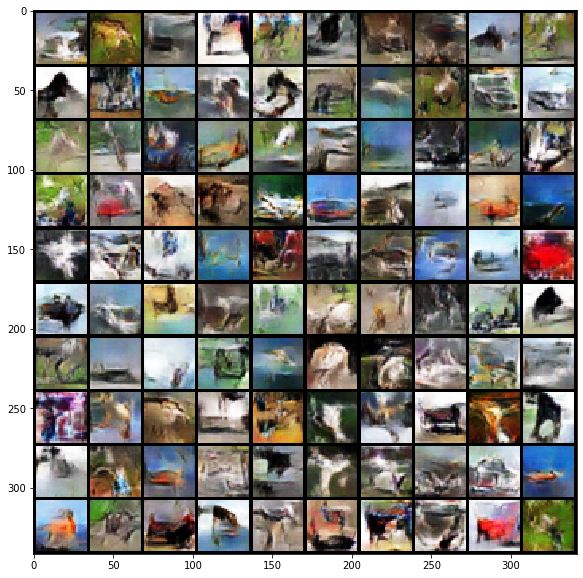

In [6]:
fake_u=NetG(fix_noise_var)
img = tv.utils.make_grid(fake_u.data[:100], nrow=10, normalize=True)
plt.figure(figsize=(10,10), facecolor='w')
plt.imshow(np.transpose(img.cpu(), (1, 2, 0)))